In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

Baixando dados

In [3]:
import os
import json

# Carregar credenciais do arquivo local
with open('.kaggle/kaggle-token.json', 'r') as f:
    credentials = json.load(f)

# Definir as variáveis de ambiente
os.environ['KAGGLE_USERNAME'] = credentials['username']
os.environ['KAGGLE_KEY'] = credentials['key']

In [4]:
from kaggle.api.kaggle_api_extended import KaggleApi

kaggle = KaggleApi()
kaggle.authenticate()

Definindo dataset

In [5]:
import kaggle

In [6]:
dataset_name = 'asaniczka/canada-optimal-product-price-prediction'

In [7]:
try:
    # Criar pasta para os dados
    os.makedirs('data', exist_ok=True)
    
    if os.path.exists('data'):
        print("Pasta 'data' criada com sucesso!")
    # Baixar e descompactar
    if not (os.path.exist('test-data/amz_ca_price_prediction_dataset.csv')):
        kaggle.api.dataset_download_files(
            dataset_name, 
            path='./test-data', 
            unzip=True
        )
    
    print("Dataset baixado com sucesso na pasta 'data'!")
    
    # Listar arquivos baixados
    import os
    arquivos = os.listdir('data')
    print("Arquivos baixados:", arquivos)
    
except Exception as e:
    print(f"Erro ao baixar: {e}")

Pasta 'data' criada com sucesso!
Erro ao baixar: module 'ntpath' has no attribute 'exist'


Lendo arquivo

In [8]:
import pandas as pd

In [9]:
dataset = pd.read_csv('test-data\\amz_ca_price_prediction_dataset.csv')

In [10]:
dataset.head(3)

,uid,asin,title,stars,reviews,price,category,isBestSeller,boughtInLastMonth
0,1,B07CV4L6HX,"Green Leaf WW3D Wonder Extension Cord Winder, ...",4.4,2876,47.69,Industrial Scientific,False,0
1,2,B09N1HGY74,8pcs Toilet Seat Bumpers Universal Toilet Repl...,3.8,55,10.99,Industrial Scientific,False,100
2,3,B087P7538J,YaeCCC 19 Pcs Hole Saw Kit 3/4''(19mm)- 6''(15...,4.0,126,25.99,Industrial Scientific,False,50


In [11]:
data = dataset.copy(deep=True)

Verificando dados nulos

In [12]:
data.isna().sum()

uid                  0
asin                 0
title                6
stars                0
reviews              0
price                0
category             0
isBestSeller         0
boughtInLastMonth    0
dtype: int64

In [13]:
data.shape

(2666481, 9)

Removendo dados nulos

In [14]:
# Quandidade de dados nulos
subset = data.isna().sum()
print('Colunas que possuem dados nulos')
for col, count in subset.items():
    if count > 0:
        print(f'{col}: {count}')

# Removendo dados nulos 
print('Removendo dados nulos')

data.dropna(inplace=True)

print("Removidos")

Colunas que possuem dados nulos
title: 6
Removendo dados nulos
Removidos


Verificando dados unicos

In [15]:
print("Verificando dados únicos e se eles aproximam da quantidade instancias")
count_unique = data.nunique().reset_index(name='count')
tamanho      = data.shape[0]

print("Criando coluna com porcentagem")
count_unique['porcentagem'] = count_unique['count'].apply(lambda x: round((x / tamanho) * 100, 2))

print("Removendo colunas com 99% de dados unicos(poder ser uma chave estrangeira)")

col = count_unique[ count_unique['porcentagem'] > 99]['index'].values 

print("Removendo colunas")
print(" =>",col)
data.drop(col, axis=1, inplace=True)

print("Removendo a coluna asin")

data.drop('asin', axis=1, inplace=True)

Verificando dados únicos e se eles aproximam da quantidade instancias
Criando coluna com porcentagem
Removendo colunas com 99% de dados unicos(poder ser uma chave estrangeira)
Removendo colunas
 => ['uid']
Removendo a coluna asin


In [16]:
data.head(2)

,title,stars,reviews,price,category,isBestSeller,boughtInLastMonth
0,"Green Leaf WW3D Wonder Extension Cord Winder, ...",4.4,2876,47.69,Industrial Scientific,False,0
1,8pcs Toilet Seat Bumpers Universal Toilet Repl...,3.8,55,10.99,Industrial Scientific,False,100


Tokenizando colunas

In [17]:
import keras
import tensorflow as tf

In [18]:
title = data['title'].str.lower()

print("Criando 256 batches para reduzir o consumo de memória")
ds = tf.data.Dataset.from_tensor_slices(title).batch(256)

print("Criando uma camada de tokenização")
LAYER = keras.layers.TextVectorization(
    output_sequence_length=60,
    standardize='lower_and_strip_punctuation',
    output_mode='int'
    )

LAYER.adapt(ds)

print('Tokenizando a coluna "title"')
tokenized_titles = ds.map(lambda x: LAYER(x)) 



Criando 256 batches para reduzir o consumo de memória
Criando uma camada de tokenização
Tokenizando a coluna "title"


In [19]:
tokens_list = []
for batch in tokenized_titles:
    tokens_list.extend(batch.numpy()) 

In [20]:
data['title_tokens'] = tokens_list

In [21]:
# removenod a coluna title
data.drop('title', axis=1, inplace=True)

In [22]:
for i in tokenized_titles:
    print(i)
    break

tf.Tensor(
[[   150    828 227923 ...      0      0      0]
 [  1660    318    245 ...      0      0      0]
 [ 29310   1737     40 ...      0      0      0]
 ...
 [ 14408    173   1125 ...      0      0      0]
 [   265   3297    577 ...      0      0      0]
 [ 60077    294     40 ...      0      0      0]], shape=(256, 60), dtype=int64)


In [23]:
from sklearn.preprocessing import LabelEncoder

def label_encoder(x):
    return LabelEncoder().fit_transform(x)
print("Atributos categoricos para numericos")

data['category'] = label_encoder(data['category'])
data['isBestSeller'] = label_encoder(data['isBestSeller'])

Atributos categoricos para numericos


Verificando outliers

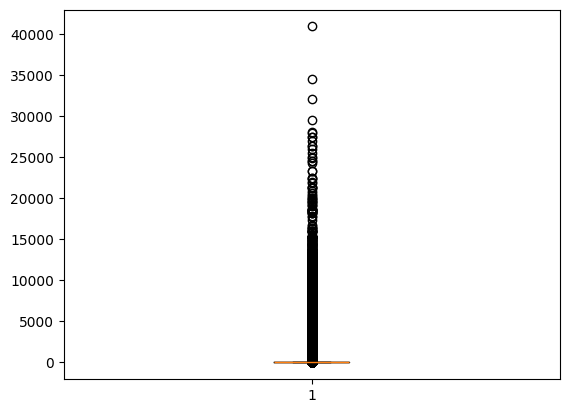

In [24]:
plt.boxplot(data['price'])
plt.show()

In [25]:
# Removendo preços menores que zero

index = data[data['price']<=0].index 
print("Será removido ", len(index), " instancias no qual o preços são menores que zero")
data.drop(index=index, inplace=True)

Será removido  194231  instancias no qual o preços são menores que zero


In [26]:
# Criando uma rede neural dos tokens
print("Criando X e y - padrão")
X = data[['stars', 'reviews','category','isBestSeller', 'boughtInLastMonth']].values
y = data['price'].values

Criando X e y - padrão


In [27]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X = scaler.fit_transform(X)

In [28]:
X = np.float32(X)

In [29]:
X.shape

(2472244, 5)

In [30]:
print("Criando X e y - tokens = Será criando uma rede neural dos tokens e será unida com padrão")
X_token = np.float32(np.stack(data['title_tokens'].values))
y = np.float32(data['price'].astype("float32").values)

Criando X e y - tokens = Será criando uma rede neural dos tokens e será unida com padrão


In [31]:
X = np.concatenate([X, X_token], axis=1)

In [32]:
from sklearn.model_selection import train_test_split

In [33]:
from sklearn.linear_model import SGDRegressor

In [ ]:
sgd = SGDRegressor()
sgd.fit(X, y)

In [ ]:
from sklearn.metrics import mean_squared_error, r2_score

In [ ]:
R2 = r2_score(y, sgd.predict(X))
MSE = mean_squared_error(y, sgd.predict(X))
print("R2: ", R2)
print("MSE: ", MSE)